In [3]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [5]:
"""
Classes
"""
class Cities:
    def __init__(self, csv):
        """
        Class containing all city objects

        Args:
        - Txt file containing cities and coordinates
        """
        # opens file
        with open(csv, "r") as f:
            lines = f.readlines()

        # reads all lines and adds them to a pandas table
        lines = lines[6:-1]
        stripped_lines = [line.strip() for line in lines]
        numbers = [[int(part) for part in line.split()] for line in stripped_lines]
        self.df = pd.DataFrame(numbers, columns=["city", "Longitude", "Latitude"])
        self.df = self.df.iloc[:, 1:]

        # add all city objects
        self.city = []
        for index, row in self.df.iterrows():
            self.city.append(City(row.name, row["Longitude"], row["Latitude"]))

class City:
    """
    Class to create one city object

    Args:
    - City integer
    - X coordinate
    - Y coordinate
    """
    def __init__(self, city, x, y):
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    """
    Class containing a certain route

    Args:
    - List[A,B] A = 1 B = The amount of cities in the route
    - Cities class, making it possible to link to all city objects
    - Perturbation, specifying the preferred perturbation when initializing
    """
    def __init__(self, list, cities_class, perturbation):
        self.cities = np.random.choice(range(list[1]), size=list[1], replace=False)
        self.route = []
        for i in self.cities:
            self.route.append(cities_class.city[i])
        self.distance = self.calculate_distance()
        self.old_route = []
        self.cities_class = cities_class
        self.perturbation = perturbation
        if self.perturbation == "two_opt":
            self.perturbation = self.two_opt
        elif self.perturbation == "move_single":
            self.perturbation = self.move_single
        else:
            raise ValueError("perturbation does not exist")


    def two_opt(self):
        """
        Performs 2-opt on the current route

        Saves the old route as well
        """
        self.old_route = self.route.copy()
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])

    def move_single(self):
        """
        Moves a single city to another location in the route
        """
        self.old_route = self.route.copy()
        # random index to move
        from_index = np.random.randint(0, len(self.route) - 1)

        # new random location for the element
        to_index = np.random.randint(0, len(self.route) - 1)

        # remove the element at from_index
        element = self.route.pop(from_index)

        # insert the element at the new location
        self.route.insert(to_index, element)

    def calculate_distance(self):
        """
        Calculates the total distance of the route
        """
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        self.distance = distance
        return distance
    
    def plot(self):
        """
        plots the route

        From: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
        """

        geometry = [Point(xy) for xy in zip(self.cities_class.df['Longitude'], self.cities_class.df['Latitude'])]
        gdf = GeoDataFrame(self.cities_class.df, geometry=geometry)   

        world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

        gdf_filtered = gdf[(gdf['Longitude'] > 0) & (gdf['Latitude'] > 0)]
        minx, miny, maxx, maxy = gdf_filtered.total_bounds  

        route_coordinates = [(city.x, city.y) for city in self.route]
        route_coordinates.append((self.route[0].x, self.route[0].y))

        # create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='black', markersize=20)
        # route
        route_gdf.plot(ax=ax, color='blue', linewidth=1)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

37
42.04759208325728
1805.8170615607896


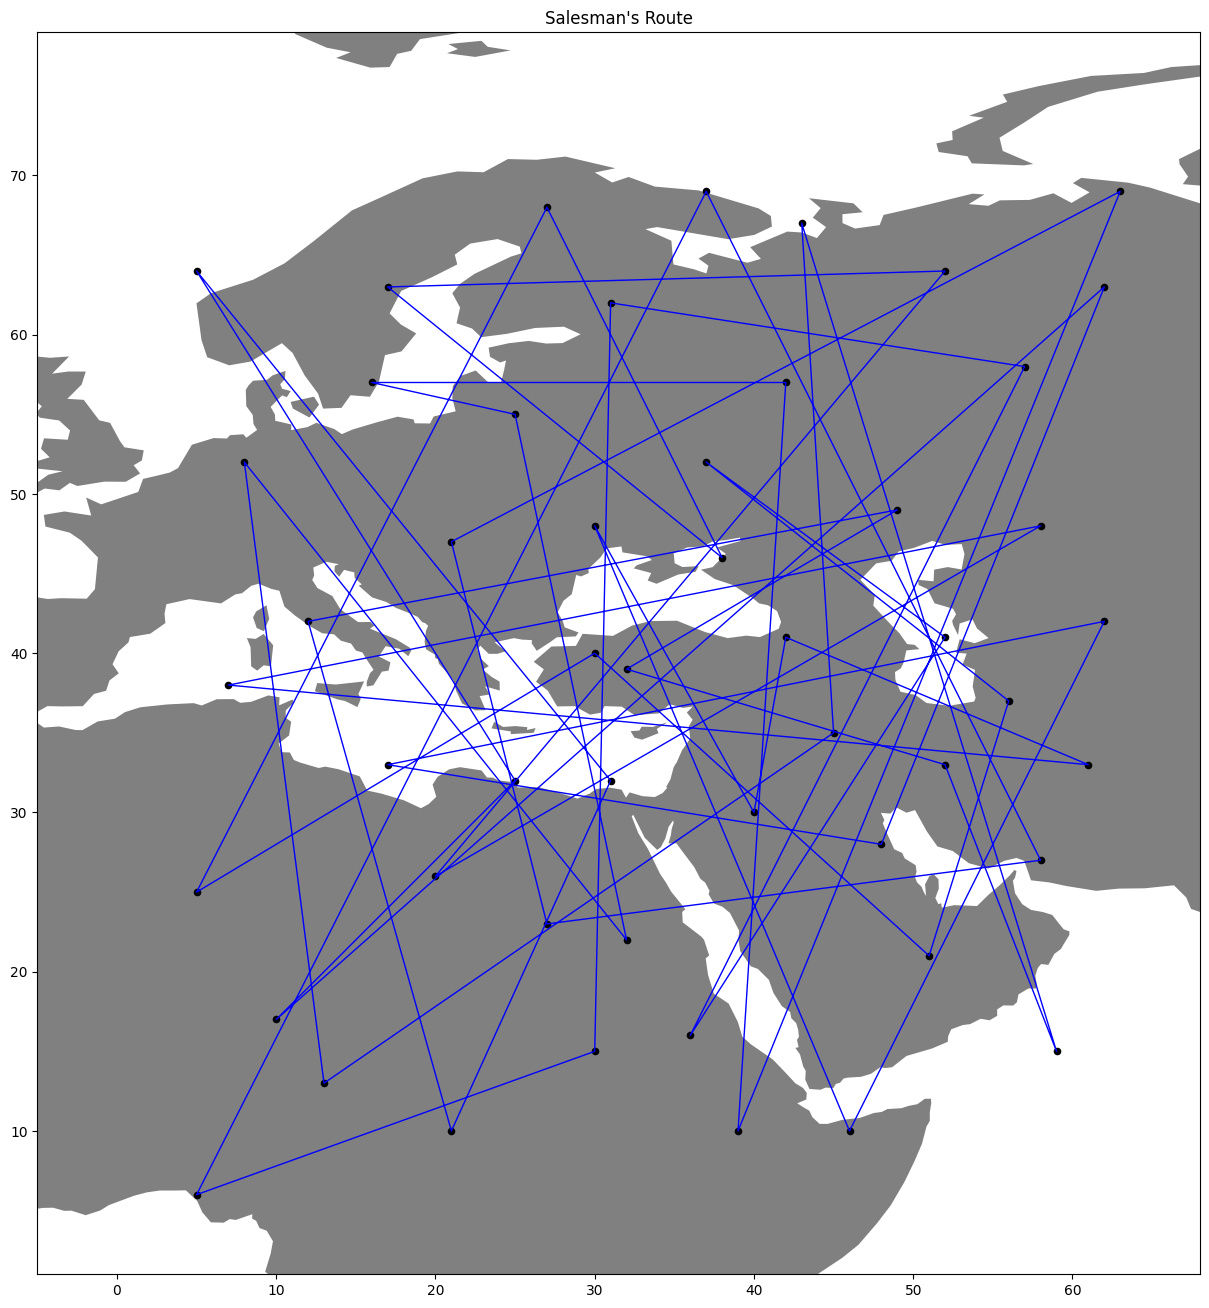

In [149]:
"""
USAGE EXAMPLES
"""
cities = Cities("eil51.tsp.txt")

print(cities.city[0].x)
print(cities.city[0].get_distance_to(cities.city[44]))

# define as the first city to the 51st city
route = Route([1,51], cities, "two_opt")
print(route.calculate_distance())
route.two_opt()
route.plot()

In [ ]:
"""
Simulated Annealing
"""
class SimmulatedAnnealing:
    """
    Class for simmulated Annealing

    Args:
    - The amount of cities in the txt file
    - txt file with the cities

    Usage:
    annealing = SimmulatedAnnealing(x,x)
    ...
    specify parameters
    ...
    annealing.run(y), where y is the amount of different runs 

    Notes:
    - Set all preferred variables beforehand otherwise it will take default values
    """
    def __init__(self, cities_amount,csv):
        self.init_temp = 1
        self.final_temp = 0.01
        self.cooling_rate = 0.95
        self.iterations = 100
        self.cities_amount = cities_amount
        self.cities = Cities(csv)
        self.mean = []
        self.sd = []
        self.data = []
        self.final_routes = []
        self.measurement_interval = 1
        self.perturbation = "two_opt"

    def run(self, runs):
        """
        Runs annealing
        """
        if self.iterations % self.measurement_interval != 0:
            raise ValueError("Iterations divided by measurement interval must be a whole number")

        self.data = np.zeros((runs, int(self.iterations/self.measurement_interval)))

        for i in range(runs):
            if i % 5 == 0:
                print(f"run {i} with {self.perturbation}")
            solutions_list = np.zeros(int(self.iterations/self.measurement_interval))
            # create new route
            route = Route([1,self.cities_amount], self.cities, self.perturbation)
            current_solution = route.calculate_distance()
            solutions_list[0] = current_solution
            current_temp = self.init_temp
            # temperatures = [current_temp]

            # iterate until the temperature is below the final temperature
            # while current_temp > self.final_temp:
            for j in range(1, self.iterations):
                # perturb 
                route.perturbation()
                perturbed_solution = route.calculate_distance()

                # define delta and accepting probability
                delta = perturbed_solution - current_solution
                exponent = min(-delta / current_temp, 700)
                probability = math.exp(exponent) 

                # if perturbed solution is better accept it as the new solution
                if delta < 0: 
                    current_solution = perturbed_solution
                # if it is worse accept it with certain probability
                elif np.random.random() < probability:
                    current_solution = perturbed_solution
                else:
                    route.route = route.old_route.copy()
                    current_solution = route.calculate_distance()

                # decrease temperature according to cooling rate
                current_temp *= self.cooling_rate
                if j % self.measurement_interval == 0:
                    solutions_list[int(j/self.measurement_interval)] = current_solution

                # temperatures.append(current_temp)
            
            self.final_routes.append(route)
            self.data[i] = solutions_list

    def give_sd_at(self, iteration):
        """
        Returns standard deviation at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.std(self.data[:, iteration])

    def give_mean_at(self, iteration):
        """
        Returns mean at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.mean(self.data[:, iteration])

    def give_all_means(self):
        """
        Returns means over all runs at all iterations in a list 
        """
        return np.mean(self.data, axis=0).tolist()

    def give_all_sd(self):
        """
        Returns standard deviation over all runs at all iterations in a list
        """
        return np.std(self.data, axis=0).tolist()
    
    def give_ci_at(self, iteration):
        """
        Returns confidence interval at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        std_dev = np.std(self.data[:, iteration])
        n = self.data.shape[0] 
        return (1.96 * std_dev / np.sqrt(n))

    def give_all_ci(self):
        """
        Returns confidence interval over all runs at all iterations in a list
        """
        std_devs = np.std(self.data, axis=0)
        n = self.data.shape[0]
        print(n)  
        return (1.96 * std_devs / np.sqrt(n)).tolist()
    
    def range(self):
        """
        Returns the amount of datapoints 

        Note: useful for plotting
        """
        return int(self.iterations/self.measurement_interval)


"""Different ways of decreasing the temperature - cooling rates """
def cooling_linear(temp_start, cooling_rate, iteration):
    return temp_start - (cooling_rate * iteration)

def cooling_exponential(temp_start, cooling_rate, iteration):
    return temp_start * (cooling_rate ** iteration)

def cooling_logarithmic(C, iteration):
    return (C/np.log(1 + iteration))

In [8]:
"""
Using it
"""
cooling_rates = [0.999, 0.95, 0.9]

two_opt_list = []
move_single_list = []

for i in range(len(cooling_rates)):
    annealing = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing.cooling_rate = cooling_rates[i]
    annealing.final_temp = 0.0001
    annealing.init_temp = 2
    annealing.iterations = 5000
    annealing.measurement_interval = 10
    annealing.perturbation = "two_opt"
    annealing.run(10)
    two_opt_list.append(annealing)

    annealing_move = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing_move.cooling_rate = cooling_rates[i]
    annealing_move.init_temp = 2
    annealing_move.iterations = 5000
    annealing_move.measurement_interval = 10
    annealing_move.perturbation = "move_single"
    annealing_move.run(10)
    move_single_list.append(annealing_move)


run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single
run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single
run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single


10
10
10
10
10
10


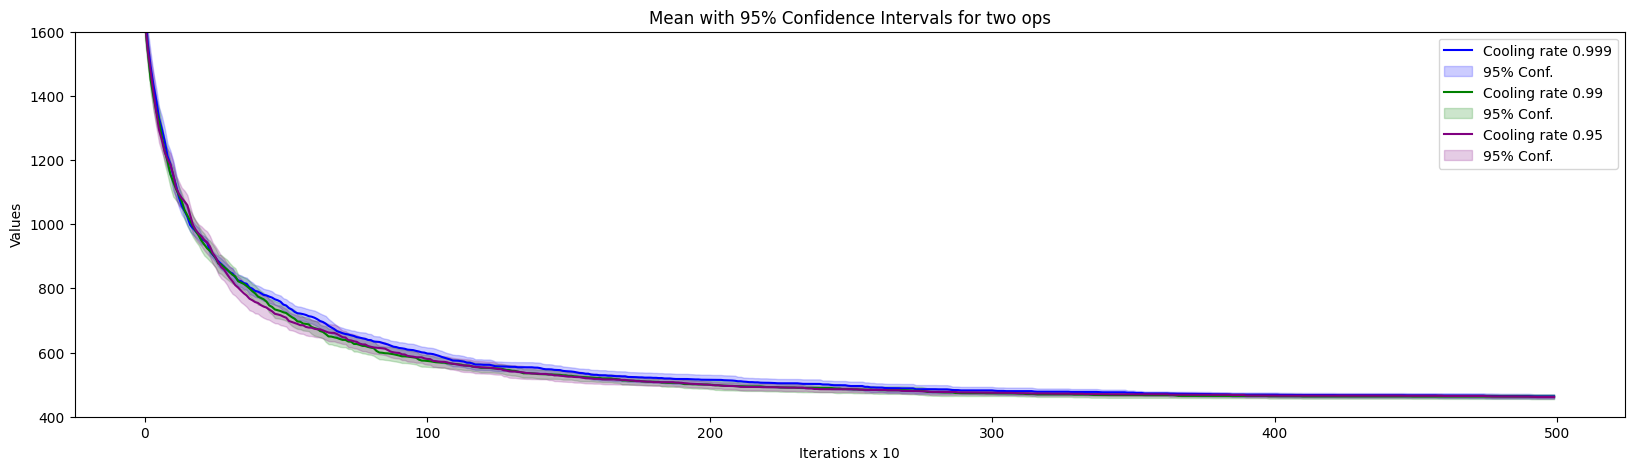

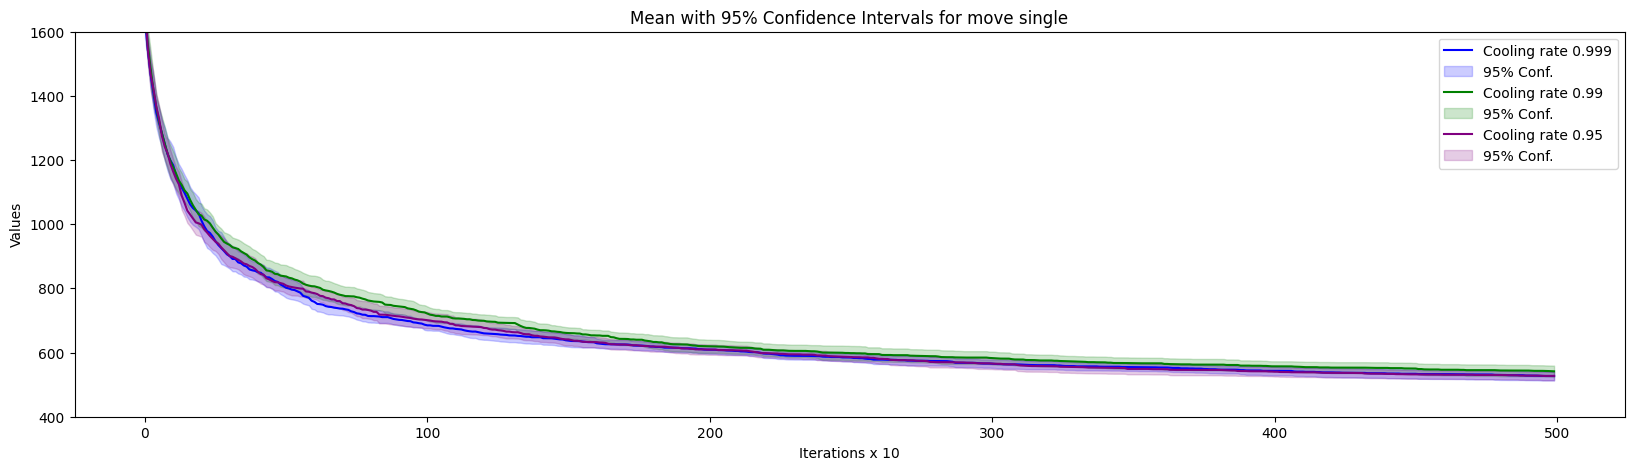

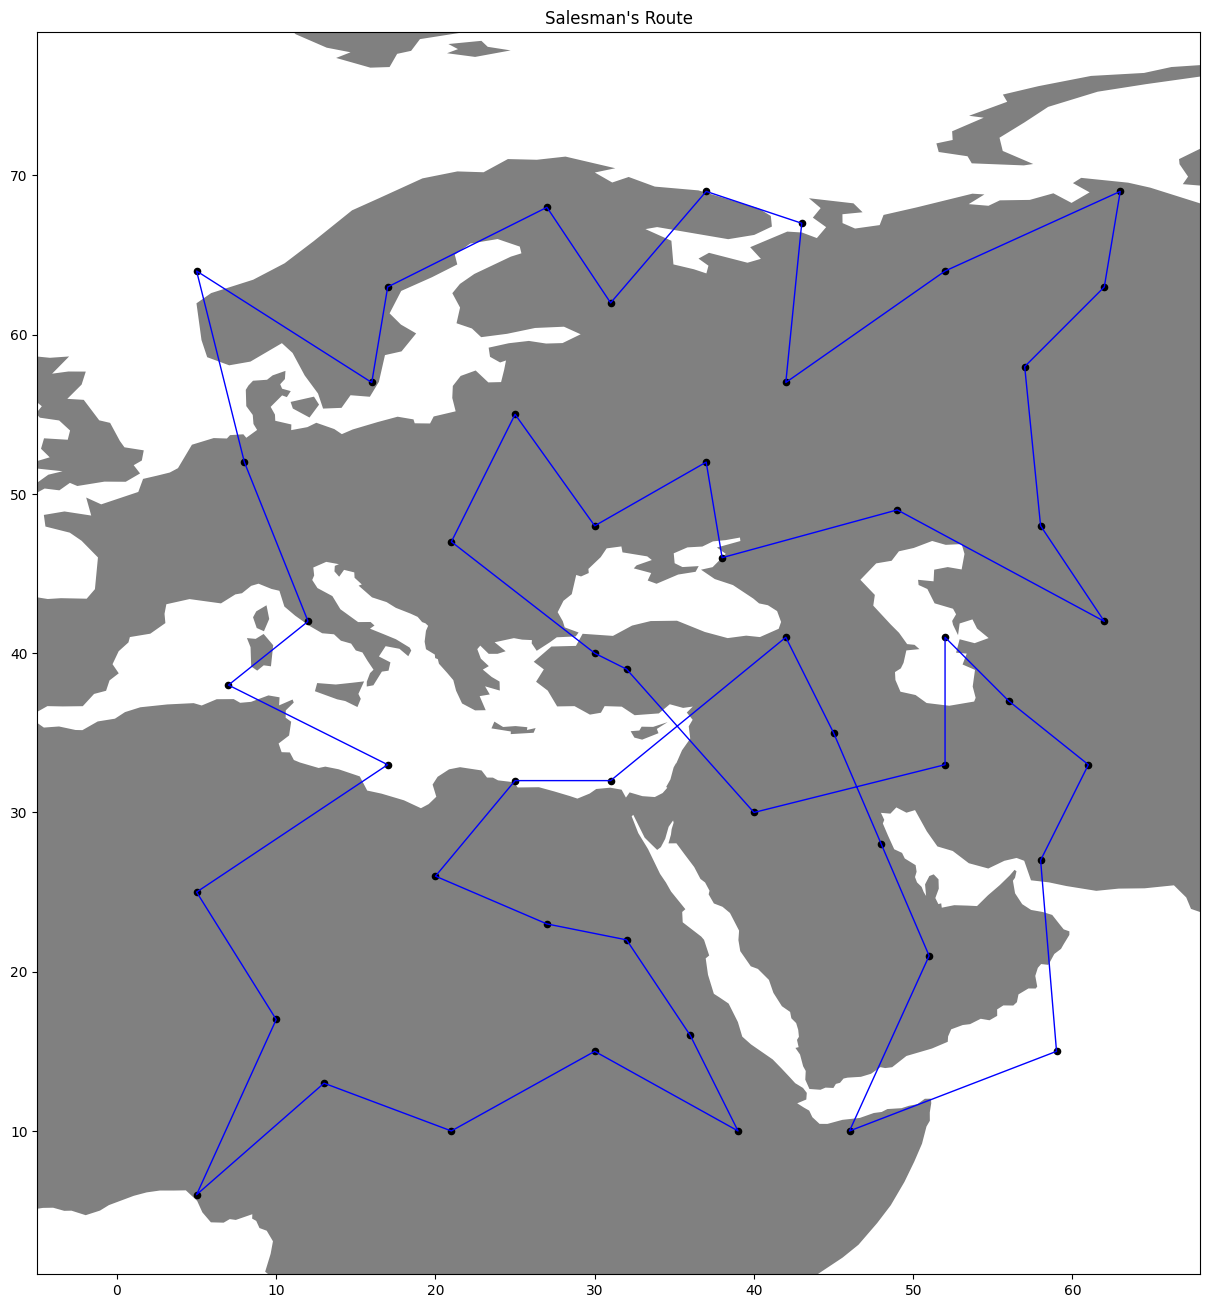

In [9]:
means_two = [two_opt_list[0].give_all_means(), two_opt_list[1].give_all_means(), two_opt_list[2].give_all_means()]
means_single = [move_single_list[0].give_all_means(), move_single_list[1].give_all_means(), move_single_list[2].give_all_means()]
ci_two = [two_opt_list[0].give_all_ci(), two_opt_list[1].give_all_ci(), two_opt_list[2].give_all_ci()]
ci_single = [move_single_list[0].give_all_ci(), move_single_list[1].give_all_ci(), move_single_list[2].give_all_ci()]

iterations = range(two_opt_list[0].range())  

colors = ["blue","green","purple"]
cooling_rates = [0.999, 0.99, 0.95]

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_two):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_two[i]),  
        np.array(mean) + np.array(ci_two[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for two ops")
plt.legend()
plt.ylim(400, 1600)

plt.show()

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_single):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_single[i]),  
        np.array(mean) + np.array(ci_single[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for move single")
plt.legend()
plt.ylim(400, 1600)

plt.show()

annealing.final_routes[5].plot()



In [ ]:
class City:
    def __init__(self, city, x, y):
        """
        - city: city integer
        - x coordinate
        - y coordinate
        """
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)
    
    def connects_to(self, city):
        """
        Connects one city to another by adding it to a list
        """
        self.connections.append(city)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    def __init__(self, route, cities):
        self.cities = cities
        self.route = [self.cities[i] for i in route]
        self.route_int = route
        self.distance = self.calculate_distance()
        self.old_route = []

    def two_opt(self):
        """
        """
        self.old_route = self.route
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])
        self.route_int[i + 1:j + 1] = reversed(self.route_int[i + 1:j + 1])

    def calculate_distance(self):
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        return distance
    
    def plot(self):
        route_coordinates = [(city.x, city.y) for city in self.cities]

        # Create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='blue', markersize=15)
        # route
        route_gdf.plot(ax=ax, color='red', linewidth=2)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"